In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import os
import shutil
import json
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
import pandas as pd
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.regularizers import l1_l2
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer, Input, Dense, Embedding, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer, Input, Dense, Embedding, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 #  **Data augmentation**

*  **check for data imbalance**
* **create dataset from directories using** *image_dataset_from_directory()*

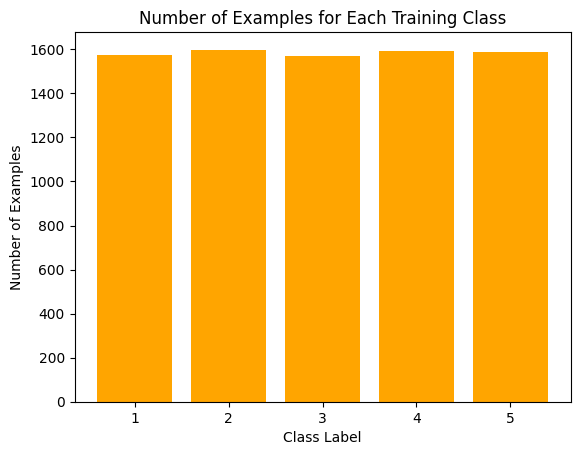

data is balanced


In [3]:
train_dir = '/kaggle/input/fruits-classification-imagestrain-valid-test/fruits_dataset/train'
valid_dir = '/kaggle/input/fruits-classification-imagestrain-valid-test/fruits_dataset/validation'
test_dir = '/kaggle/input/fruits-classification-imagestrain-valid-test/fruits_dataset/test'

class_directories = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Initialize lists to store class labels and corresponding example counts
class_labels = []
example_counts = []

# Iterate through class directories
for class_dir in class_directories:
    class_label = int(class_dir)  # Assuming class directories are named as '1', '2', '3', ...
    class_path = os.path.join(train_dir, class_dir)
    num_examples = len(os.listdir(class_path))
    
    class_labels.append(class_label)
    example_counts.append(num_examples)

# Plot the histogram
plt.bar(class_labels, example_counts, color='orange')
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.title('Number of Examples for Each Training Class')
plt.show()

print('data is balanced')

In [4]:
img_height, img_width = 300, 300
# img_height, img_width = 224, 224
batch_size = 32



train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=123,
        shuffle=True,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        valid_dir,
        seed=123,
        shuffle=True,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )

Autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=Autotune)

Found 7920 files belonging to 5 classes.
Found 1980 files belonging to 5 classes.


In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomFlip("vertical"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomCrop(height=300, width=300),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomContrast(0.2),
        preprocessing.Rescaling(1./255)
    ])

    return data_augmentation

data_augmentation = data_augmenter()

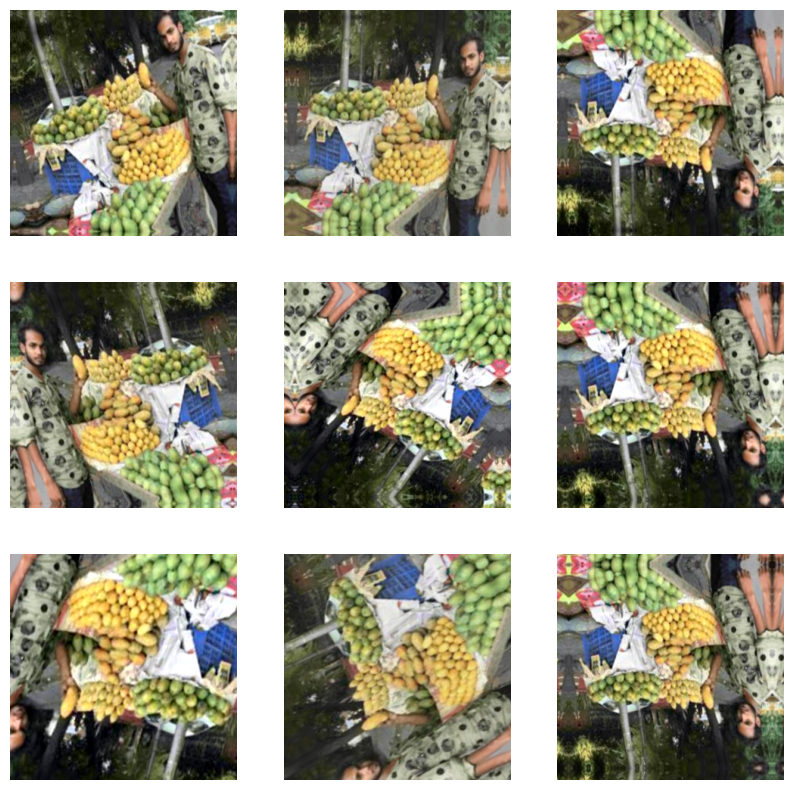

In [6]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[2]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] )
        plt.axis('off')


# **EfficientNetB3 Model Imolementation**
* **Simple Implementation**
![](https://miro.medium.com/v2/resize:fit:1400/0*FJos7uXvl-uLDpSQ.png)

In [7]:
def EfficientNetB3(input_shape=(300, 300, 3), num_classes=5, dropout_rate=0.2, l2_reg=0.001):
    # Input layer
    input_tensor = layers.Input(shape=input_shape)
    
    #applying data augmentaton to the training data
    augmented_input = data_augmenter()(input_tensor)

    # Stem convolution
    x = layers.Conv2D(40, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializers.he_normal())(augmented_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Build blocks
    x = efficientnet_block(x, 24,  3, 1, 2, name='block1')
    x = efficientnet_block(x, 32,  3, 2, 2, name='block2')
    x = efficientnet_block(x, 48,  5, 2, 2, name='block3')
    x = efficientnet_block(x, 96,  3, 1, 2, name='block4')
    x = efficientnet_block(x, 136, 5, 2, 2, name='block5')
    x = efficientnet_block(x, 332, 5, 1, 2, name='block6')
    x = efficientnet_block(x, 384, 3, 1, 2, name='block7')

    # Top convolution
    x = layers.Conv2D(1536, (1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializers.he_normal())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Fully connected layer for classification
    output_tensor = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg), kernel_initializer=initializers.he_normal())(x)

    # Create the model
    model = models.Model(inputs=input_tensor, outputs=output_tensor, name='EfficientNetB3')
    return model

def efficientnet_block(x, filters, kernel_size, strides, expand_ratio, name):
    channels = int(filters * expand_ratio)
    x_expand = layers.Conv2D(channels, (1, 1), padding='same', use_bias=False, name=name + '_expand')(x)
    x_expand = layers.BatchNormalization(name=name + '_expand_BN')(x_expand)
    x_expand = layers.Activation('swish', name=name + '_expand_swish')(x_expand)

    x_dw = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False, name=name + '_depthwise')(x_expand)
    x_dw = layers.BatchNormalization(name=name + '_depthwise_BN')(x_dw)
    x_dw = layers.Activation('swish', name=name + '_depthwise_swish')(x_dw)

    # Squeeze and Excitation
    se = layers.GlobalAveragePooling2D(name=name + '_SE_GlobalAvg')(x_dw)
    se = layers.Reshape((1, 1, channels), name=name + '_SE_Reshape')(se)
    se = layers.Conv2D(int(channels * 0.25), (1, 1), activation='swish', padding='same', use_bias=False, name=name + '_SE_1')(se)
    se = layers.Conv2D(channels, (1, 1), activation='sigmoid', padding='same', use_bias=False, name=name + '_SE_2')(se)
    x_dw = layers.Multiply(name=name + '_SE_Multiply')([x_dw, se])

    x_project = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False, name=name + '_project')(x_dw)
    x_project = layers.BatchNormalization(name=name + '_project_BN')(x_project)

    if strides == 1 and x.shape[-1] == filters:
        x_project = layers.Add(name=name + '_add')([x, x_project])

    return x_project

# **VGG16 Model Implementation**
* **Simple Implementation**

![](https://miro.medium.com/v2/resize:fit:470/0*Ha2hz5QXG1rFXJd5.png)

In [ ]:
def VGG16(input_shape=(224, 224, 3), num_classes=5):
    model = models.Sequential()
    model.add(data_augmentation)

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    layers.Dropout(0.2)

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    layers.Dropout(0.2)

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    layers.Dropout(0.2)

    # Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    layers.Dropout(0.2)

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    layers.Dropout(0.2)

    
    
    # model.add(layers.Flatten())
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    layers.Dropout(0.5)
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    layers.Dropout(0.5)
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# **Vision Transformer VIT Model Implementation**

![](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

In [70]:
class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 16, 16, 1],
            strides=[1, 16, 16, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(Layer):
    def __init__(self, num_patches=196, projection_dim=384):  # Reduced projection_dim
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        class_token = tf.tile(self.class_token, multiples=[batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        encoded = patches_embed + positions_embed
        return encoded

    
    
# class PatchExtractor(Layer):
#     def __init__(self):
#         super(PatchExtractor, self).__init__()

#     def call(self, images, training=True):
#         if training:
#             batch_size = tf.shape(images)[0]
#             patches = tf.image.extract_patches(
#                 images=images,
#                 sizes=[1, 16, 16, 1],
#                 strides=[1, 16, 16, 1],
#                 rates=[1, 1, 1, 1],
#                 padding="VALID",
#             )
#             patch_dims = patches.shape[-1]
#             patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#             return patches
#         else:
#             return images  # For inference, just return the original image


# class PatchEncoder(Layer):
#     def __init__(self, num_patches=196, projection_dim=384):
#         super(PatchEncoder, self).__init__()
#         self.num_patches = num_patches
#         self.projection_dim = projection_dim
#         w_init = tf.random_normal_initializer()
#         class_token = w_init(shape=(1, projection_dim), dtype="float32")
#         self.class_token = tf.Variable(initial_value=class_token, trainable=True)
#         self.projection = Dense(units=projection_dim)
#         self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

#     def call(self, patch, training=True):
#         batch = tf.shape(patch)[0]
#         class_token = tf.tile(self.class_token, multiples=[batch, 1])
#         class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
#         patches_embed = self.projection(patch)
#         patches_embed = tf.concat([patches_embed, class_token], 1)
#         positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
#         positions_embed = self.position_embedding(positions)
#         encoded = patches_embed + positions_embed
#         return encoded

    
    
    
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

class Block(Layer):
    def __init__(self, projection_dim, num_heads=2, dropout_rate=0.1):  # Reduced num_heads
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        x1 = self.norm1(x)
        attention_output = self.attn(x1, x1)
        x2 = Add()([attention_output, x])
        x3 = self.norm2(x2)
        x3 = self.mlp(x3)
        y = Add()([x3, x2])
        return y

class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=2, num_blocks=1, dropout_rate=0.1):  # Reduced num_blocks
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.3)  # Adjusted dropout rate

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

def create_VisionTransformer(num_classes=5, num_patches=196, projection_dim=384, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
#     augmented_inputs = data_augmentation(inputs) 
    patches = PatchExtractor()(inputs)
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    logits = MLP(projection_dim, num_classes, 0.3)(representation)
    model = Model(inputs=inputs, outputs=logits)
    return model


# **Model Training**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

def custom_scheduler(epoch, logs):
    if epoch == 0:
        lr = 0.001
    elif epoch < 10:
        lr = 0.001 * epoch
    elif epoch < 50:
        lr = 0.0001 * (epoch / 100) 
    elif epoch < 90:
        lr = 0.0001 * (epoch/1000) 
    else:
        lr = 0.0001 * (epoch/10000)

    print(f'Learning Rate for Epoch {epoch + 1}: {lr}')
    return lr

lr_scheduler = LearningRateScheduler(custom_scheduler)

# loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model = EfficientNetB3()
# model = VGG16()
# model = create_VisionTransformer()

model.compile(optimizer = Adam(lr=lr_scheduler), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

history = model.fit(train_dataset,
                        epochs=250,
                        validation_data=valid_dataset,
                        callbacks=[early_stopping, lr_scheduler])

print('trainign is done')

In [ ]:
model = create_VisionTransformer()

# learning_rate = 0.001
num_epochs = 250

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=learning_rate,
#     decay_steps=1000,
#     decay_rate=0.9,
#     staircase=True)

def custom_scheduler(epoch, logs):
    if epoch == 0:
        lr = 0.001
    elif epoch < 10:
        lr = 0.001 * epoch
    elif epoch < 50:
        lr = 0.0001 * (epoch / 100) 
    elif epoch < 90:
        lr = 0.0001 * (epoch/1000) 
    else:
        lr = 0.0001 * (epoch/10000)

    print(f'Learning Rate for Epoch {epoch + 1}: {lr}')
    return lr

lr_scheduler = LearningRateScheduler(custom_scheduler)

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)


model.compile(optimizer=Adam(lr=lr_scheduler), loss=loss_fn, metrics=[accuracy_metric])


model.summary()


history = model.fit(train_dataset, epochs=num_epochs, validation_data=valid_dataset)

# **Plotting Accuracy VS Epochs & Learning_loss VS Epochs**

> # **CNN models Plot**

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# Print validation accuracy
validation_accuracy = history.history['val_accuracy']
print("Validation accuracy:", validation_accuracy[-1])

In [ ]:
plt.figure(figsize=(20, 6))

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')



# Show the plot
plt.show()

# Print validation accuracy and loss
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
print("Validation accuracy:", validation_accuracy[-1])
print("Validation loss:", validation_loss[-1])

> # **Vision Transformer (VIT) model Plot**

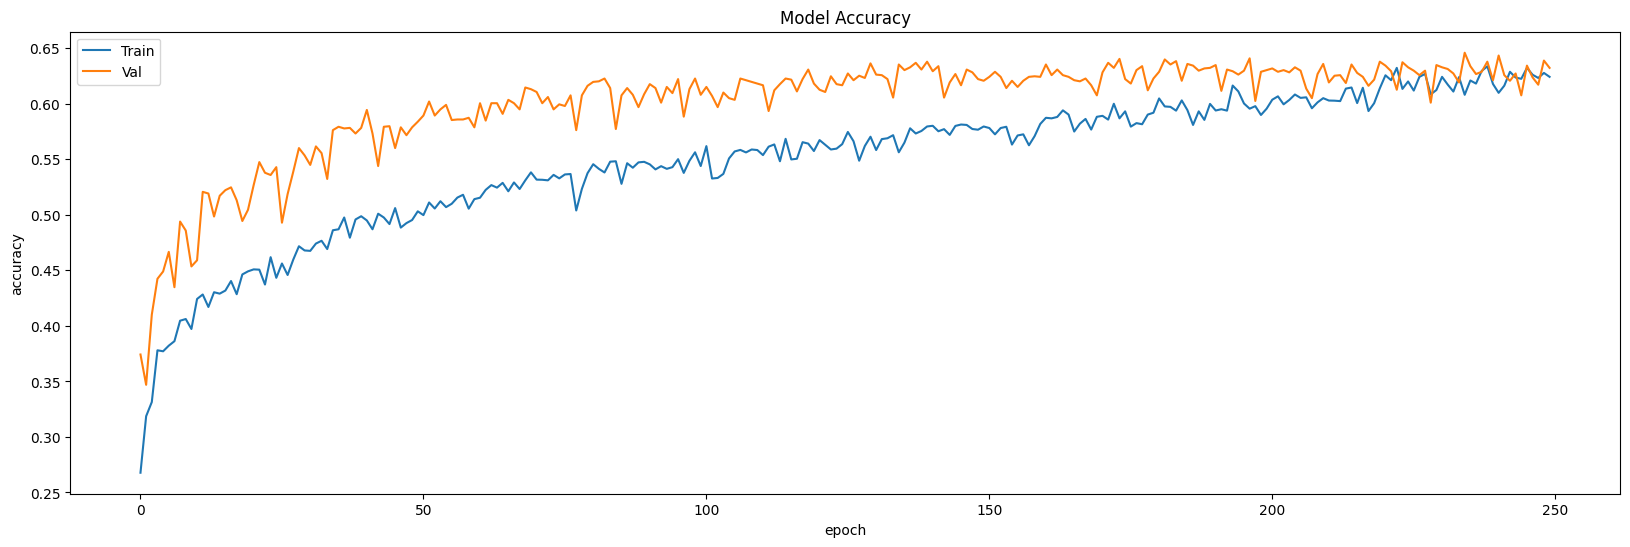

Validation accuracy: 0.6323232054710388


In [74]:
plt.figure(figsize=(20, 6))
plt.plot(history.history['sparse_categorical_accuracy'])  # Use 'sparse_categorical_accuracy' instead of 'accuracy'
plt.plot(history.history['val_sparse_categorical_accuracy'])  # Use 'val_sparse_categorical_accuracy' instead of 'val_accuracy'
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Print validation accuracy
validation_accuracy = history.history['val_sparse_categorical_accuracy']  # Use 'val_sparse_categorical_accuracy'
print("Validation accuracy:", validation_accuracy[-1])


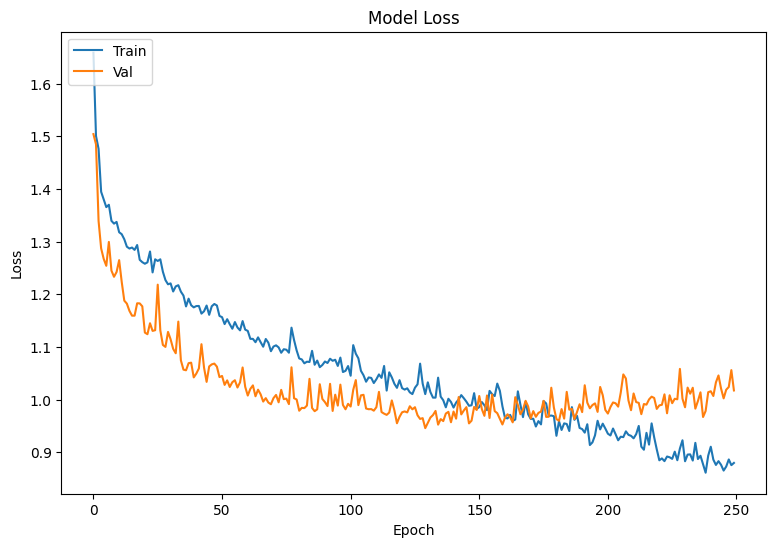

Validation accuracy: 0.6323232054710388
Validation loss: 1.0174998044967651


In [75]:
plt.figure(figsize=(20, 6))

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Show the plot
plt.show()

# Print validation accuracy and loss
validation_accuracy = history.history['val_sparse_categorical_accuracy']  # Use 'val_sparse_categorical_accuracy'
validation_loss = history.history['val_loss']
print("Validation accuracy:", validation_accuracy[-1])
print("Validation loss:", validation_loss[-1])


# **Saving Models for Testing**

In [ ]:
model.save("EfficentNetB3_v11.h5")
print('Model saved')

In [ ]:
model.save("VGG16_v1.h5")
print('Model saved')

In [1]:
model.save("VIT_v3.h5")
print('Model saved')

NameError: name 'model' is not defined

# **Plotting the Confusion Matrix**

1/1 [==============================] - 0s 23ms/step
list of predictions:  [3, 2, 5, 2, 4, 1, 2, 5, 4, 1, 3, 3, 2, 1, 3, 3, 4, 3, 3, 5, 1, 5, 5, 4, 2, 3, 5, 1, 2, 1, 2, 5, 1, 3, 4, 3, 5, 2, 2, 4, 3, 1, 2, 3, 1, 1, 4, 2, 3, 4, 2, 3, 5, 2, 4, 4, 1, 3, 5, 5, 3, 4, 1, 1, 4, 3, 4, 3, 1, 1, 3, 3, 5, 4, 3, 1, 2, 4, 5, 2, 5, 4, 2, 5, 3, 2, 2, 4, 3, 1, 1, 3, 2, 2, 4, 2, 1, 2, 3, 3]
Accuracy: 57.00%


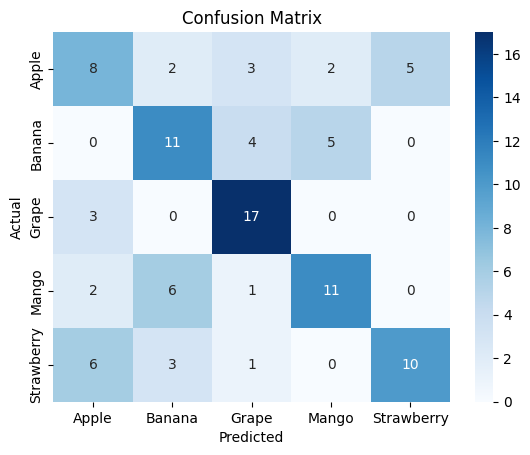

In [77]:
model = create_VisionTransformer()
model.load_weights('/kaggle/working/VIT_v2.h5')

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# model = load_model('/kaggle/input/saved-models/EfficentNetB3_v11.h5')

# List only the image filenames from the test directory and its subdirectories
test_filenames = []
for root, dirs, files in os.walk(test_dir):
    for filename in files:
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            test_filenames.append(os.path.join(root, filename))

# Rest of your code remains unchanged
class_labels = sorted(os.listdir(train_dir))
predictions = []

for img_path in test_filenames:
    img_name, _ = os.path.splitext(os.path.basename(img_path))  # Extract only the image name without extension
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # No preprocessing applied to img_array

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    predictions.append(predicted_class)

predictions = [int(pred) for pred in predictions]
print('list of predictions: ', predictions)
print('======================================================')

class_labels = [1, 2, 3, 4, 5]
class_names = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
conf_matrix = confusion_matrix(Actual, predictions, labels=class_labels)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

# **CSV submission file**

In [15]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

model = load_model('/kaggle/input/false-hope/EfficentNetB3_v13.h5')

# List only the image filenames from the test directory and its subdirectories
test_filenames = []
for root, dirs, files in os.walk(test_dir):
    for filename in files:
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            test_filenames.append(os.path.join(root, filename))

# Rest of your code remains unchanged
class_labels = sorted(os.listdir(train_dir))
predictions = []

for img_path in test_filenames:
    img_name, _ = os.path.splitext(os.path.basename(img_path))  # Extract only the image name without extension
    img = load_img(img_path, target_size=(300, 300))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # No preprocessing applied to img_array

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    predictions.append(predicted_class)

predictions = [int(pred) for pred in predictions]
print('list of predictions: ', predictions)



submission_data = []

for img_path, prediction in zip(test_filenames, predictions):
    img_name, _ = os.path.splitext(os.path.basename(img_path))
    submission_data.append({'image_id': img_name, 'label': prediction})

# Create a DataFrame from the list
submission_df = pd.DataFrame(submission_data, columns=['image_id', 'label'])

# Display the first few rows of the DataFrame (optional)
print(submission_df.head())

# Save the DataFrame to a CSV file
submission_df.to_csv('/kaggle/working/submission_v5.csv', index=False)

print("Submission file created successfully.")

1/1 [==============================] - 0s 21ms/step
list of predictions:  [2, 4, 5, 2, 2, 2, 5, 5, 4, 1, 3, 3, 1, 5, 2, 3, 4, 4, 3, 5, 4, 5, 5, 4, 2, 1, 1, 5, 2, 1, 5, 5, 1, 3, 4, 3, 5, 2, 2, 4, 3, 5, 2, 3, 2, 5, 2, 5, 4, 4, 2, 4, 5, 2, 4, 4, 5, 3, 1, 5, 2, 2, 5, 1, 2, 3, 4, 4, 5, 1, 3, 3, 5, 1, 2, 1, 4, 2, 5, 2, 5, 1, 2, 5, 5, 2, 2, 4, 2, 3, 3, 3, 4, 4, 4, 2, 1, 2, 3, 2]
  image_id  label
0     1266      2
1     1862      4
2      311      5
3     3362      2
4     3652      2
Submission file created successfully.


In [10]:
model = tf.keras.models.load_model('/kaggle/input/best-so-far-1/EfficentNetB3_v12.h5')

# Print model summary to see layer names
model.summary()

# Access the weights of a specific layer
layer_name = 'dense'
layer_weights = model.get_layer(layer_name).get_weights()

# Now, you can inspect the weights
print(f"Weights for {layer_name}: {layer_weights}")

Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 40)         1080      ['sequential_1[0][0]']        
                                                                                                  
 batch_normalization (Batch  (None, 150, 150, 40)         160       ['conv2d[0][0]']              
 Normalization)                                                                      

In [14]:
model = tf.keras.models.load_model('/kaggle/input/saved-models/EfficentNetB3_v11.h5')

# Print model summary to see layer names
model.summary()

# Access the weights of a specific layer
layer_name = 'dense_10'
layer_weights = model.get_layer(layer_name).get_weights()

# Now, you can inspect the weights
print(f"Weights for {layer_name}: {layer_weights}")

Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 300, 300, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 150, 150, 40)         1080      ['sequential_9[0][0]']        
                                                                                                  
 batch_normalization_14 (Ba  (None, 150, 150, 40)         160       ['conv2d_53[0][0]']           
 tchNormalization)                                                                   